#### Feature extraction experiments
This experiments are intended to test the performance of the model when using the feature extraction technique. The idea is to use the pre-trained model as a feature extractor and then train a new model using the extracted features. 

The features area extracted ahead of time and saved for performance reasons. The caveat is that we can not use the data augmentation techniques when extracting the features.

In [1]:
%load_ext autoreload
%autoreload 2

#### Vit Feature extraction
* Load the feature extractor model
* Load the dataloaders for training and testing 
* Iterate and extract the features (save in a list of batches)
* Check memory
* Create a new Dataset with the extracted features

In [1]:
from drecg.data.utils import create_dataloader_train, create_dataloader_test, create_dataloader_validation, preview_image_data
from drecg.models.feat_extraction import VitFeatureExtractor
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feat_extractor = VitFeatureExtractor(device)

In [33]:
from torchvision.transforms import ToPILImage, Compose, RandomHorizontalFlip, RandomRotation, RandomAdjustSharpness, RandomAutocontrast, ColorJitter
train_transform = Compose([
    ColorJitter(brightness=0.3, saturation=0.1, hue=0.05),
    RandomAutocontrast(p=0.9),
    RandomHorizontalFlip(p=0.9),
    RandomRotation(degrees=10),
    RandomAdjustSharpness(sharpness_factor=0.5, p=0.9),
    feat_extractor.transforms
])
train_dataloader = create_dataloader_train(transforms=feat_extractor.transforms)
train_augmented_dataloader = create_dataloader_train(transforms=train_transform)
test_dataloader = create_dataloader_test(transforms=feat_extractor.transforms)
validation_dataloader = create_dataloader_validation(transforms=feat_extractor.transforms)

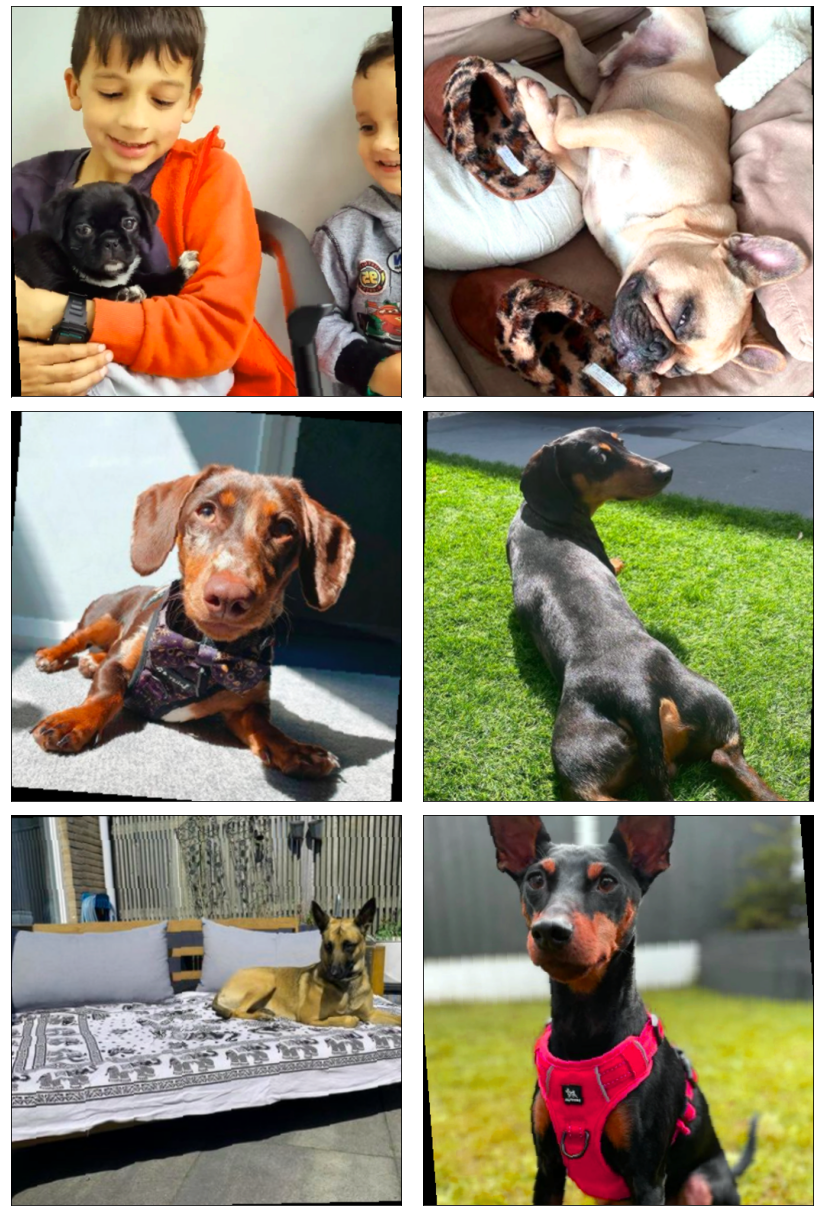

In [37]:
transforms = Compose([feat_extractor.reverse_preprocess, ToPILImage()])
preview_image_data(train_augmented_dataloader.dataset, transforms=transforms)

In [38]:
from tqdm.auto import tqdm
import torch
def extract_features(dataloader, feat_extractor, data = []):
    bar = tqdm(range(len(dataloader)))

    feat_extractor.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            features_a, features_b = feat_extractor(x_batch)

            features_a = features_a.detach().cpu()
            features_b = features_b.detach().cpu()
            features = (features_a, features_b)

            torch.cuda.empty_cache()
            data.append((features, y_batch))
            bar.update(1)
    return data        

root_dir = 'features_ext_vit'

In [5]:
test_features = extract_features(test_dataloader, feat_extractor)
train_features = extract_features(train_dataloader, feat_extractor)
validation_features = extract_features(validation_dataloader, feat_extractor)

torch.save(test_features, f'{root_dir}/test_features.pt')
torch.save(train_features, f'{root_dir}/train_features.pt')
torch.save(validation_features, f'{root_dir}/validation_features.pt')

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [39]:
train_features = extract_features(train_dataloader, feat_extractor)
train_augmented_features = extract_features(train_augmented_dataloader, feat_extractor, data=train_features)
train_augmented_features = extract_features(train_augmented_dataloader, feat_extractor, data=train_augmented_features)
torch.save(train_augmented_features, f'{root_dir}/train_features_augmented.pt')

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [40]:
len(train_augmented_features)

366